## Información integrantes del equipo de trabajo
**Nombre y apellidos (Grupo): Elodie Curcio**

**Nombre y apellidos (Grupo): Guillermo Díaz**

**Nombre y apellidos (Grupo): Miguel Quiroga**

# Dinámica molecular


Para estudiar la dinámica molecular de un fluido o un gas mediante simulaciones podemos resolver las ecuaciones en derivadas totales

$$ m_i\frac{d^2\vec{r}_i(t)}{dt^2} = \vec{F}_i(t)\, ,$$

donde $i$ hace referencia a la partícula $i$-ésima, $\vec{r}_i(t)$ es el vector posición de la partícula en el instante $t$, $m_i$ la mása de la partícula, y $\vec{F}_i(t)$ la fuerza total que siente la partícula a causa de todas las demás en el instante $t$. Definido un potencial de interacción podemos calcular la fuerza. En nuestro caso consideremos el potencial de Lennard-Jones:

$$V(d) = 4\epsilon\left[\left(\frac{\sigma}{d}\right)^{12}-\left(\frac{\sigma}{d}\right)^6\right]\, ,$$

donde $d$ es la distancia entre las partículas,$\epsilon$ la magnitud del mínimo, y $\sigma$ se relaciona con el tamaño efectivo de las partículas. A partir de este potencial, tenemos que

$$\vec{F}_i = -\vec{\nabla}V_i = \sum_{j\neq i} 4\epsilon\left[12\frac{\sigma^{12}}{d_{i,j}^{13}}-6\frac{\sigma^6}{d_{i,j}^7}\right]\hat{r}_{i\rightarrow j}\, ,$$

siendo $\hat{r}_{i\rightarrow j}$ el vector unitario en la dirección $i\rightarrow j$ que conecta las partículas.

## Apartado a:

- Considere una partícula que se mueve dentro de una caja de tamaño L=1 cuadrada en dos dimensiones. Considerar condiciones de contorno fijas (pared rígida). Para ello resolved numéricamente el sistema de ecuaciones diferenciales, por un método numérico. Representad la posición de la partícula a lo largo del tiempo en el plano $XY$. Considerar rebotes elásticos. **EXTRA** Probad a añadir gravedad al problema de una sola partícula.

In [255]:
# Librerías

from numpy import linspace, array, sqrt, sin, zeros, arange, ndarray, where, isnan, fill_diagonal, meshgrid, cos, sin, save, load, mean, exp
from numpy.linalg import norm
from numpy.random import normal, random
from math import pi, ceil
from pylab import plot, show, scatter, xlabel, ylabel, axis, vlines, hlines, xlim, ylim, title, legend, hist


In [104]:
def f(r: ndarray, gravity, potentialCalc = False) -> ndarray:
    """
    Función de evolución de todas las partículas.

    Parámetros
    ----------

    r : ndarray
        Posiciones y velocidades de todas las partículas para un único tiempo.
    """
    particles = r.shape[0]
    xPos = r[:, 0]
    yPos = r[:, 1]
    xVel = r[:, 2]
    yVel = r[:, 3]
    fun = zeros([particles, 4], float)
    fun[:, 0] = xVel
    fun[:, 1] = yVel
    if potentialCalc:
        fun[:, 2:], potential = force(r, gravity, potentialCalc)
        return fun, potential # early return para evitar más cálculos
    fun[:, 2:] = force(r, gravity, False)
    return fun
    # return array([fxPos, fyPos, fxVel, fyVel], float)

def force(r: ndarray, gravity, potentialCalc) -> ndarray:
    """
    Calcula la fuerza en cada partícula para un único tiempo.

    Parámetros
    ----------

    r : ndarray
        Posiciones y velocidades de todas las partículas para un único tiempo.
    """
    particles = r.shape[0]
    finalForce = zeros([particles, 2], float)

    global sigma, epsilon, tol, mass

    # calculamos las distancias relativas y los vectores relativos
    particleRel = zeros([particles, particles, 2], float)
    for i in range(particles):
        particleRel[i, :, :] = r[:, 0:2]
    particleRelPos = zeros([particles, particles], float)
    particleRelPos = ((particleRel[:,:,0] - particleRel[:,:,0].T)**2 + (particleRel[:,:,1] - particleRel[:,:,1].T)**2)**0.5 # this should be illegal, but it really works

    fill_diagonal(particleRelPos, float('inf')) # ignoramos la diagonal (interacciones entre la misma partícula)

    particleRelVec = zeros([particles, particles, 2], float)
    particleRelVec[:, :, 0] = (particleRel[:,:,0]-particleRel[:,:,0].T) / -particleRelPos
    particleRelVec[:, :, 1] = (particleRel[:,:,1]-particleRel[:,:,1].T) / -particleRelPos

    particleRelPos = where(particleRelPos >= tol*2, float('inf'), particleRelPos) # para evitar la fuerza atractiva que existe justo antes de la repulsiva
    particleRelPos = where(particleRelPos < tol, tol, particleRelPos) # para evitar fuerzas muy altas

    particleForce = zeros([particles, particles, 2], float)
    particleForce[:,:,0] = 4*epsilon * ( 12*sigma**12/particleRelPos**13 - 6*sigma**6/particleRelPos**7 ) * particleRelVec[:,:,0]
    particleForce[:,:,1] = 4*epsilon * ( 12*sigma**12/particleRelPos**13 - 6*sigma**6/particleRelPos**7 ) * particleRelVec[:,:,1]
    
    if gravity != None:
        finalForce[:, 1] -= gravity

    if potentialCalc:
        finalPotential = zeros([particles], float)
        potential = 4*epsilon * ( (sigma/particleRelPos)**12 - (sigma/particleRelPos)**6 )
        for i in range(particles):
            finalPotential[i] = sum(potential[i,:])
            finalForce[i,0] += sum(particleForce[i,:,0])
            finalForce[i,1] += sum(particleForce[i,:,1])
        return finalForce/mass, finalPotential # early return para evitar más cálculos

    for i in range(particles):
        finalForce[i,0] += sum(particleForce[i,:,0])
        finalForce[i,1] += sum(particleForce[i,:,1])

    return finalForce/mass


def partEvolve(r: ndarray, timeMax: float, timeStep: float, boxSize, gravity = None): # aka rungeKutta4
    """
    Cálculo de evolución de todas las partículas.

    Parámetros
    ----------

    r : ndarray
        Condiciones inciales de posiciones y velocidades de todas las partículas.
    """
    time = arange(0,timeMax+timeStep, timeStep)
    particles = r.shape[0]
    positions = zeros([particles, 2, time.size], float) # pre-alocamos las posiciones
    velocities = zeros([particles, 2, time.size], float) # pre-alocamos las velocidades
    potentials = zeros([particles, time.size], float) # pre-alocamos las energías potenciales
    for i in range(time.size):
        positions[:, 0, i] = r[:, 0]
        positions[:, 1, i] = r[:, 1]
        velocities[:, 0, i] = r[:, 2]
        velocities[:, 1, i] = r[:, 3]
        print(f'time = {round(time[i],1)}/{round(time[-1],1)}', end='\r') # progreso
        
        k1, potentials[:, i] = f(r, gravity, True)
        k2 = timeStep * f(r + timeStep * k1/2, gravity)
        k3 = timeStep * f(r + k2/2, gravity)
        k4 = timeStep * f(r + k3, gravity)
        r += (timeStep * k1 + 2*k2 + 2*k3 + k4) / 6

        # box check

        # x axis check
        r[:, 2] = where(abs(r[:,0]) >= boxSize/2, -r[:, 2], r[:, 2])
        # y axis check
        r[:, 3] = where(abs(r[:,1]) >= boxSize/2, -r[:, 3], r[:, 3])

        # # x axis check
        # indicesVelChange = where(abs(r[:,0]) >= boxSize/2)[0]
        # for index in indicesVelChange:
        #     r[index, 2] *= -1
        # # y axis check
        # indicesVelChange = where(abs(r[:,1]) >= boxSize/2)[0]
        # for index in indicesVelChange:
        #     r[index, 3] *= -1

        # if abs(r[0]) >= boxSize/2: # x fuera de la caja
        #     r[2] *= -1
        # if abs(r[1]) >= boxSize/2: # y fuera de la caja
        #     r[3] *= -1
        
    # positions = zeros([2,time.size], float)
    # positions[0,:] = array(x)
    # positions[1,:] = array(y)
    return positions, velocities, potentials

def plotBox(boxSize):
    """
    Representa una caja del tamaño indicado centrada en (0,0).
    """
    vlines(boxSize/2,-boxSize/2,boxSize/2,'k')
    vlines(-boxSize/2,-boxSize/2,boxSize/2,'k')
    hlines(boxSize/2,-boxSize/2,boxSize/2,'k')
    hlines(-boxSize/2,-boxSize/2,boxSize/2,'k')
    xlim([-boxSize/2, boxSize/2])
    ylim([-boxSize/2, boxSize/2])
    axis('equal')

def plotParticles(positions: ndarray):
    """
    Representa la trayectoria de todas las partículas.
    """
    particles = positions.shape[0]
    for part in range(particles):
        plot(positions[part, 0, :], positions[part, 1, :])


In [171]:
# TEST PLATFORM

particles = 3
r = zeros([particles, 4], float) # inicializa posiciones y velocidades
r[0,0], r[0,2] = 0.2001, -0.2
r[1,0], r[1,2] = -0.5, 0.2
r[2,0], r[2,2] = 0.2, 0.2

particleRel = zeros([particles, particles, 2], float)
for i in range(particles):
    particleRel[i, :, :] = r[:, 0:2]
particleRelPos = zeros([particles, particles], float)
particleRelPos = ((particleRel[:,:,0] - particleRel[:,:,0].T)**2 + (particleRel[:,:,1] - particleRel[:,:,1].T)**2)**0.5 # this should be illegal, but it really works

fill_diagonal(particleRelPos, float('inf')) # ignoramos la diagonal (interacciones entre la misma partícula)

particleRelVec = zeros([particles, particles, 2], float)
particleRelVec[:, :, 0] = (particleRel[:,:,0]-particleRel[:,:,0].T) / -particleRelPos
particleRelVec[:, :, 1] = (particleRel[:,:,1]-particleRel[:,:,1].T) / -particleRelPos

particleRelPos = where(particleRelPos >= tol*2, float('inf'), particleRelPos) # para evitar la fuerza atractiva que existe justo antes de la repulsiva
particleRelPos = where(particleRelPos < tol, tol, particleRelPos) # para evitar fuerzas muy altas

particleForce = zeros([particles, particles, 2], float)
particleForce[:,:,0] = 4*epsilon * ( 12*sigma**12/particleRelPos**13 - 6*sigma**6/particleRelPos**7 ) * particleRelVec[:,:,0]
particleForce[:,:,1] = 4*epsilon * ( 12*sigma**12/particleRelPos**13 - 6*sigma**6/particleRelPos**7 ) * particleRelVec[:,:,1]

print(particleRelPos)

[[ inf  inf 0.01]
 [ inf  inf  inf]
 [0.01  inf  inf]]


In [39]:
# Variables globales
boxSize = 1
mass = 1
sigma = 0.015
epsilon = 0.4
# sigma = 0.01
# epsilon = 0.5
tol = 0.01
timeStep = 1e-4

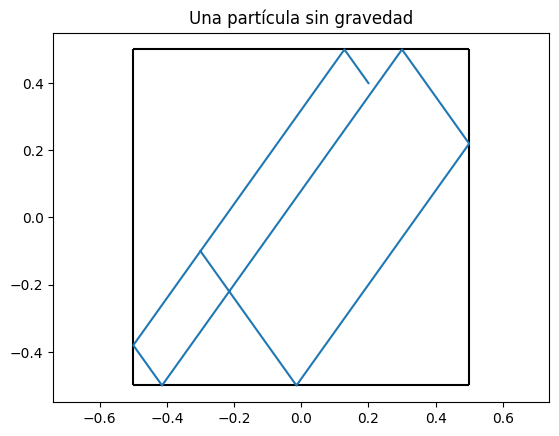

In [44]:
r = zeros([1, 4], float)
r[0,:] = array([0.2, 0.4, -0.5, 0.7], float)
timeMax = 5
timeStep = 1e-4
positions = partEvolve(r, timeMax, timeStep, boxSize, gravity = None)[0]
plotParticles(positions)
plotBox(boxSize)
title('Una partícula sin gravedad')
show()

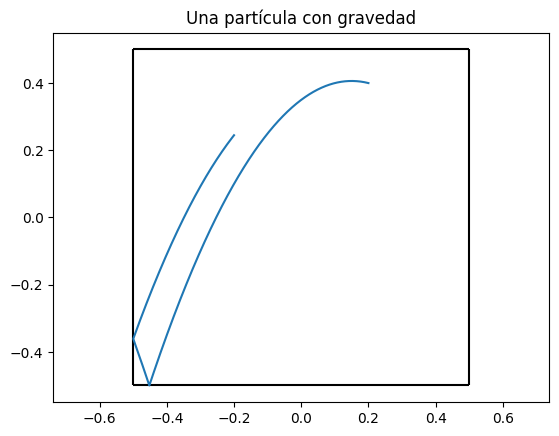

In [45]:
r = zeros([1, 4], float)
r[0,:] = array([0.2, 0.4, -0.2, 0.05], float)
timeMax = 5
timeStep = 1e-4
positions = partEvolve(r, timeMax, timeStep, boxSize, gravity = 0.2)[0]
plotParticles(positions)
plotBox(boxSize)
title('Una partícula con gravedad')
show()

- Incluir una segunda partícula interactuante al problema. Representar la posición de las dos particulas en el plano $XY$, así como la evolución de cada coordenada en el tiempo.  Tomad $\epsilon\sim0.5$ y $\sigma\sim0.01$. **AYUDA** Empezad considerando particulas no interactuantes y luego añadir la interacción. Posicionar las dos partículas y darles velocidades iniciales tales que colisionen para comprobar que la interacción se lleva acabo correctamente.

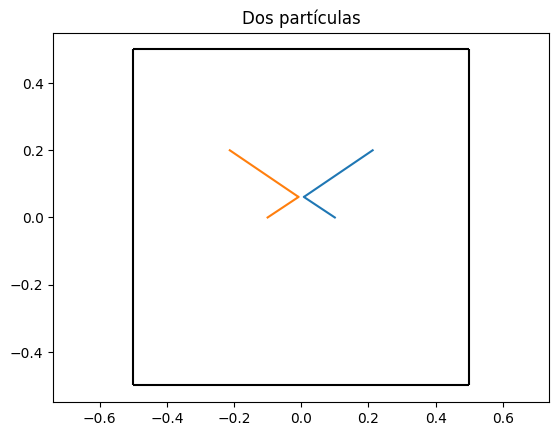

In [47]:
particles = 2
timeMax = 1
timeStep = 1e-3

r = zeros([particles, 4], float) # inicializa posiciones y velocidades
# r[0,0], r[0,2] = 0.1, -1.5
# r[1,0], r[1,2] = -0.1, 1.5
r[0,0], r[0,2], r[0,3] = 0.1, -0.3, 0.2
r[1,0], r[1,2], r[1,3] = -0.1, 0.3, 0.2

positions = partEvolve(r, timeMax, timeStep, boxSize, gravity = None)[0]

plotParticles(positions)
plotBox(boxSize)
title('Dos partículas')
show()


- Generalizar el programa para considerar $N$ partículas. **CONSEJOS**:
    - Se recomienda tener una matriz que contenga toda la información de las partículas $[(x_i,y_i,v^{(x)}_i,v^{(y)}_i)]$.
    - Empezad considerando pocas particulas e id aumentando el numero de ellas.
    - En el cálculo de la fuerza de interacción, puede darse que dos partículas estén muy juntas, de forma que la aceleración que sienten es muy grande. Se recomienda usar un "cut_off", el cual puede consistir en la transformación $r_{ij}<tol\rightarrow r_{ij}=tol$, donde es recomendable tomar $tol\sim 0.01$ (puede ser necesario ajustar el valor de $tol$ según los valores exactos de $\sigma$ y $\epsilon$ tomados. Para ello se recomienda representar la fuerza en función de la distancia para los valores tomados).
    - Para determinar las posiciones iniciales, es aconsejable crear una cuadrícula centrada en la caja y posicionar las partículas en los nodos de la misma. Para esto pueden ser útiles la función ``mesgrid`` y ``flatten`` de ``numpy``.
    - Para las velocidades, se recomienda generar de forma aleatoria un ángulo que determine la dirección y el módulo del vector velocidad para cada partícula. Este último se recomienda generarlo con una distribución gaussiana, de média 0.5 y desviación 0.1.
    - Cuantas más partículas consideremos, menor debe ser el $\Delta t$ para evitar "perdernos" colisiones. Esto implica que necesitaremos hacer más iteraciones para representar el mismo periodo de tiempo. Se recomienda ir ajustando el numero de partículas, el $\Delta t$ y el número de iteraciones poco a poco, empezando por valores razonables y nunca considerando cantidades demasiado grandes).
    - Posiblemente, la simulación final (con mayor cantidad de partículas, por ejemplo, 100-200, y más larga) tarde un tiempo en ejecutarse. Una vez generados esos datos, se recomienda escribirlos en un fichero para facilitar el resto del trabajo.

In [343]:
def randomStart(particles, boxSize, wallSep = 'Auto') -> ndarray:
    r = zeros([particles, 4], float)

    # if particles == 1:
    #     r[:,:2] = 0
    #     return r

    gridRes = ceil(particles**0.5) # cantidad de puntos en cada dimensión de la cuadrícula
    
    if wallSep == 'Auto':
        wallSep = boxSize/(gridRes+1)

    x = linspace(-boxSize/2+wallSep, boxSize/2-wallSep, gridRes)
    y = linspace(-boxSize/2+wallSep, boxSize/2-wallSep, gridRes)
    x, y = meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()

    r[:,0] = x[:particles]
    r[:,1] = y[:particles]

    angle = random(particles)*2*pi
    velMod = normal(0.5, 0.1, particles)
    r[:,2] = cos(angle)*velMod
    r[:,3] = sin(angle)*velMod

    return r

[[-0.16666667 -0.16666667  0.59365155 -0.16666703]
 [ 0.16666667 -0.16666667  0.38860878 -0.0679097 ]
 [-0.16666667  0.16666667  0.39242537 -0.32710289]
 [ 0.16666667  0.16666667  0.4473774   0.39254917]]


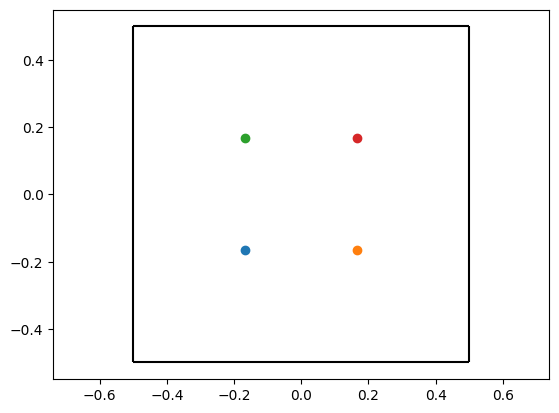

In [552]:
particles = 4
r = randomStart(particles, 1, 'Auto')
for i in range(particles):
    scatter(r[i,0], r[i,1])
plotBox(1)
print(r)

In [168]:
particles = 50
r = randomStart(particles, 1, 'Auto')
timeMax = 5
timeStep = 1e-4

positions, velocities, potentials = partEvolve(r, timeMax, timeStep, boxSize)

save('positions', positions)
save('velocities', velocities)
save('potentials', potentials)

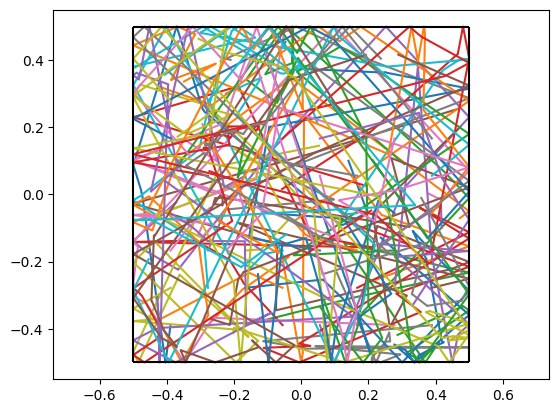

In [169]:
positions = load('positions.npy')
plotParticles(positions)
plotBox(boxSize)
show()

## Apartado b:

- Usando las posiciones y velocidades del último 10% de las iteraciones realizadas en la simulación, calculad la energía cinética, potencial y total del sistema a lo largo del tiempo y representarlas en un gráfico.

In [314]:
def energy(velocities, potentials, start = 0, end = 1, plots: str = '111') -> tuple[ndarray]:
    indexHigh = int(velocities.shape[2]*end)
    indexLow = int(velocities.shape[2]*start)
    iterTotal = indexHigh-indexLow

    global mass
    energyPot = sum(potentials[:,indexLow:])
    energyKin = 1/2 * mass * sum( norm(velocities[:,:,indexLow:], axis=1) )
    energyTot = energyKin + energyPot

    if plots[0] == '1':
        plot(energyKin, label='Energía cinética')
    if plots[1] == '1':
        plot(energyPot, label='Energía potencial')
    if plots[2] == '1':
        plot(energyTot, label='Energía total')
    if '1' in plots:
        legend()
        xlabel('Iteraciones')
        ylabel('E')
        title(f'Energías del {round(start*100)}% al {round(end*100)}% de iteraciones.')
        show()
    return energyKin, energyPot, energyTot

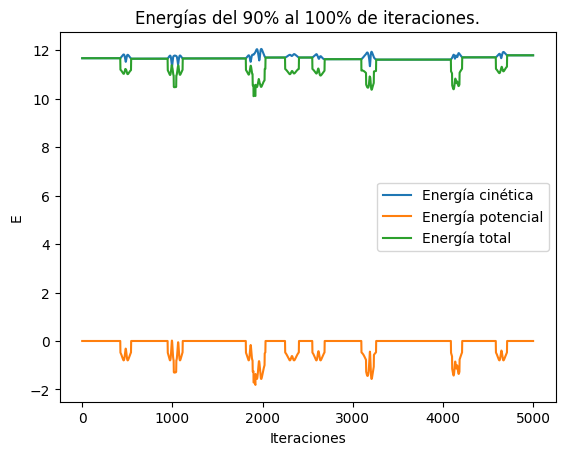

In [315]:
velocities = load('velocities.npy')
potentials = load('potentials.npy')

energyKin, energyPot, energyTot = energy(velocities, potentials, 0.9, plots = '111')


- Haced un histograma del módulo de las velocidades a lo largo del último 10% de las iteraciones para todas las partículas y superponer la función de distribución teórica:

$$p(v) = \frac{v}{K_BT}e^{-v^2/2K_BT}\, ,$$

donde el valor de $K_BT$ se puede estimar a partir de la energía cinética média por partícula haciendo uso del Teorema de equipartición (recordad que el sistema es de dos dimensiones). **AYUDA** En caso de que los datos no ajusten muy bien a la curva, puede ser por que no se ha hecho una simulación suficientemente larga y por tanto no se a alcanzado el equilibrio térmico.

In [310]:
def velProb(v, energyKin, particles):
    """
    Calcula la probabilidad teórica para cada velocidad extrayendo la temperatura del sistema a partir del teorema de equipartición.

    Parámetros
    ----------
    v : float or ndarray
        Velocidad o rango de velocidades.
    energyTot : float
        Energía total del sistema para deducir la temperatura.
    particles : int
        Número de partículas del sistema para deducir la temperatura.


    Notas
    -----
    El teorema de equipartición indica que cada grado de libertad de una partícula contribuye con `kT/2` a la energía total.

    Por tanto, sabiendo que estamos en dos dimensiones, la energía total es `E = kT · particles`, debido a los dos grados de libertad traslacionales.
    """
    kT = energyKin/particles
    prob = v/kT * exp( -v**2/(2*kT) )
    return prob


def histVel(velocities, start = 0, end = 1):
    indexHigh = int(velocities.shape[2]*end)
    indexLow = int(velocities.shape[2]*start)
    iterTotal = indexHigh-indexLow

    velMod = norm(velocities[:,:,indexLow:], axis=1)
    energyKin = 1/2 * mass * sum( velMod )
    velMod = velMod.flatten()

    v = linspace(velMod.min(), velMod.max(), 100)
    probVel = velProb(v, energyKin[-1], velocities.shape[0])
    hist(velMod, density=True)
    plot(v, probVel)
    xlabel('$v$')
    ylabel('Frecuencia')
    title('Histograma del módulo de las velocidades')
    show()
    # return probVel


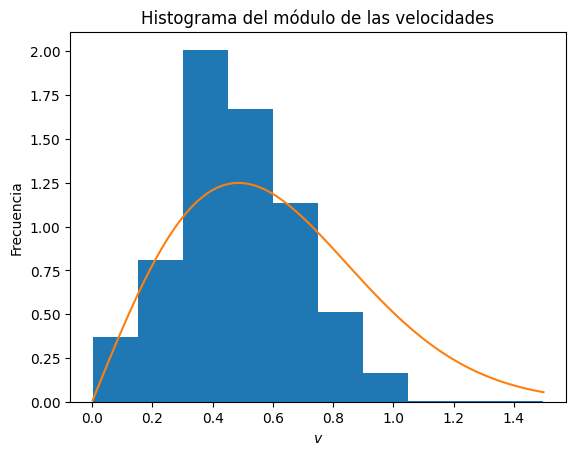

In [311]:
probVel = histVel(velocities)
# probVel.max()

## Apartado c:

- Repetid la simulación considerando una velocidad media nula y una desviacion de 0.25. Repedid el apartado b para estos nuevos datos. ¿Qué conclusiones podéis sacar?